## Example of the affect of defining misspecified prior densities on branch lengths

Amine Remita

In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from nnTreeVB.data import evolve_seqs_full_homogeneity    
from nnTreeVB.data import build_tree_from_nwk
from nnTreeVB.data import simulate_tree
from nnTreeVB.data import build_msa_categorical
from nnTreeVB.data import TreeSeqCollection
#
from nnTreeVB.checks import check_sim_blengths
from nnTreeVB.checks import check_sim_simplex
#
from nnTreeVB.reports import plot_weights_grads_epochs
from nnTreeVB.reports import violinplot_from_dataframe
#
from nnTreeVB.models.vb_models import VB_nnTree
from nnTreeVB.models.evo_models import compute_log_likelihood
#
from nnTreeVB.utils import compute_rates_from_kappa

In [72]:
import time
import math
import random
import copy
from pprint import pprint
from collections import OrderedDict

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=5)

In [73]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', "r'All-NaN (slice|axis) encountered'")

In [74]:
verbose = True

device = torch.device("cpu")
# # device = torch.device("cuda")

In [75]:
# seed = 49685
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Sequence alignment simulation

In [76]:
## Define a function to simulate complete dataset (sequence alignment + tree)
## Branch lengths will be sampled from an exponential distribution with a mean defined by the user

def simulate_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=1000,
    nb_taxa=32,
    blen_mean=0.001,
    rates_str="0.16",
    freqs_str="0.25",
    verbose=0):

    # Simulate branch lengts
    rate = 1 / blen_mean
    sim_blengths = check_sim_blengths("exponential({})".format(rate), nb_taxa)[0]
    
    if verbose:
        print("Simulated brench lengths:")
        print("Number: {}".format(len(sim_blengths)))
        print("Mean: {}".format(np.mean(sim_blengths)))
        print("Variance: {}".format(np.var(sim_blengths)))
        print("Tree length: {}".format(np.sum(sim_blengths)))

    # Simulate tree
    tree_data = simulate_tree(nb_taxa, sim_blengths, seed)

    the_tree = tree_data[0]
    taxa = list(tree_data[1].keys())

    str_tree = the_tree.write(format=1) # get newick string
    the_tree.write(format=1, outfile=tree_file)
    
    # Sequence evolutionary parameters simulation
    sim_rates = check_sim_simplex(rates_str, 6)[0]
    #
    sim_freqs = check_sim_simplex(freqs_str, 4)[0]
    sim_freqs[1], sim_freqs[2] = sim_freqs[2], sim_freqs[1] # order of nuc is different in pyvolve

    # Sequence simulation using pyvolve
    all_seqdict = evolve_seqs_full_homogeneity(
        str_tree,
        fasta_file=False,
        nb_sites=alignment_len,
        subst_rates=sim_rates,
        state_freqs=sim_freqs,
        return_anc=True,
        verbose=verbose)

    sequences = [all_seqdict[s] for s in taxa]
    seq_taxa = {s:all_seqdict[s] for s in taxa}
    
    # write fasta file
    records = [SeqRecord(Seq(seq_taxa[taxon]), taxon, '', '') for taxon in seq_taxa]
    SeqIO.write(records, fasta_file, "fasta")
    
    # Extract branch lengths from the tree
    true_branches = torch.zeros(len(the_tree.get_descendants()))
    # print(true_branches.shape[0])

    for node in the_tree.traverse("postorder"):
        if node.postrank < true_branches.shape[0]:
            true_branches[node.postrank] = node.dist

    true_branches = true_branches.unsqueeze(-1)

    if verbose:
        print("\ntrue_branches")
        print(len(true_branches))
        print(true_branches.sum())

    # Build a treeSeq collection
    treeseqs = TreeSeqCollection(fasta_file, tree_file)
    tree_obj = treeseqs.tree
    logl_tree = copy.deepcopy(tree_obj)
    
    # Compress the alignment to get the site patterns
    motifs_cats = build_msa_categorical(treeseqs, nuc_cat=False)
    x = torch.from_numpy(motifs_cats.data)
    x, x_counts = x.unique(dim=0, return_counts=True)

    return true_branches, tree_obj, x, x_counts

In [77]:
## Test function
fasta_file = 'sim.fasta'
tree_file = 'sim.nw'

blens, obj_tree, X, X_counts = simulate_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=1000,
    nb_taxa=32,
    blen_mean=0.001, verbose=1)

Simulated brench lengths:
Number: 61
Mean: 0.0008526261552825608
Variance: 1.2449080591739317e-06
Tree length: 0.05201019547223621
Evolving sequences with the amazing Pyvolve

true_branches
61
tensor(0.0520)


## Fitting and sampling nnTreeVB models

In [78]:
def fit_sample_vb_model(
    # init and fit hyperparams
    tree_obj,
    x,
    x_counts,
    #
    subs_model="jc69",
    # branch lengths prior hyperparams
    b_prior_dist="exponential",
    b_prior_params=[10.],
    b_learn_prior=False,
    #
    # Rates prior hyperparams
    r_prior_dist="dirichlet",
    r_prior_params=[1.]*6,
    r_learn_prior=False,
    #
    # Freqs prior hyperparams
    f_prior_dist="dirichlet",
    f_prior_params=[1.]*4,
    f_learn_prior=False,
    #
    elbo_type="elbo",
    grad_samples=torch.Size([1]),
    alpha_kl=1.,
    max_iter=1000,
    optimizer="adam",
    learning_rate=0.1,
    weight_decay=0.0,
    scheduler_lambda=lambda epoch: 1.0,
    save_fit_history=False,
    save_grad_stats=False,
    save_weight_stats=False,
    verbose=2,

    # sampling hyperparams
    nb_samples = torch.Size([1000])):

    if verbose:
        print("\tInitialize the model")
    
    model = VB_nnTree(
        copy.deepcopy(tree_obj),
        subs_model=subs_model,
        
        ## Branch lengths
        # Prior hyperparams
        b_prior_dist=b_prior_dist,
        b_prior_params=b_prior_params,
        b_learn_prior=b_learn_prior,
        # Variational hyperparams
        b_var_dist="normal",
        b_var_params=[0.1, 0.1],
        b_var_transform=torch.distributions.ExpTransform(),
        
        ## GTR Rates
        # Prior hyperparams
        r_prior_dist=r_prior_dist,
        r_prior_params=r_prior_params,
        r_learn_prior=r_learn_prior,
        # Variational hyperparams
        r_var_dist="normal",
        r_var_params=[0.1, 0.1],
        r_var_transform=torch.distributions.StickBreakingTransform(),

        ## GTR Freqs
        # Prior hyperparams
        f_prior_dist=f_prior_dist,
        f_prior_params=f_prior_params,
        f_learn_prior=f_learn_prior,
        # Variational hyperparams
        f_var_dist="normal",
        f_var_params=[0.1, 0.1],
        f_var_transform=torch.distributions.StickBreakingTransform(),
        
        ##
        device="cpu"
    )
    
    if verbose:
        print("\tFit the model")

    model.fit(
        x, 
        x_counts,
        elbo_type=elbo_type,
        grad_samples=grad_samples,
        alpha_kl=alpha_kl,
        max_iter=max_iter,
        optimizer=optimizer,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        scheduler_lambda=scheduler_lambda,
        save_fit_history=save_fit_history,
        save_grad_stats=save_grad_stats,
        save_weight_stats=save_weight_stats,
        verbose=verbose
    )
    
    if verbose:
        print("\tSample from the model")
    
    samples = model.sample(
        x, 
        x_counts,
        elbo_type=elbo_type,
        alpha_kl=alpha_kl,
        nb_samples=nb_samples
    )
    
    return model, samples

In [79]:
## Test function
model, samples = fit_sample_vb_model(obj_tree, X, X_counts)

	Initialize the model
	Fit the model
0m 0s	Epoch: 10	ELBO: -26494.023	LogL: -26256.070	LogP: -136.998	LogQ: 100.956	KL: 237.953
0m 0s	Epoch: 20	ELBO: -11786.735	LogL: -11656.652	LogP: 35.623	LogQ: 165.706	KL: 130.083
0m 0s	Epoch: 30	ELBO: -6499.681	LogL: -6366.717	LogP: 91.562	LogQ: 224.526	KL: 132.964
0m 0s	Epoch: 40	ELBO: -4538.687	LogL: -4400.196	LogP: 111.937	LogQ: 250.428	KL: 138.491
0m 0s	Epoch: 50	ELBO: -3730.960	LogL: -3573.359	LogP: 120.484	LogQ: 278.085	KL: 157.601
0m 0s	Epoch: 60	ELBO: -3300.361	LogL: -3145.780	LogP: 124.909	LogQ: 279.489	KL: 154.581
0m 0s	Epoch: 70	ELBO: -3054.860	LogL: -2894.601	LogP: 127.538	LogQ: 287.797	KL: 160.260
0m 1s	Epoch: 80	ELBO: -2864.069	LogL: -2686.586	LogP: 129.709	LogQ: 307.192	KL: 177.483
0m 1s	Epoch: 90	ELBO: -2745.410	LogL: -2573.511	LogP: 130.911	LogQ: 302.809	KL: 171.898
0m 1s	Epoch: 100	ELBO: -2682.013	LogL: -2500.874	LogP: 131.678	LogQ: 312.817	KL: 181.139
0m 1s	Epoch: 110	ELBO: -2602.465	LogL: -2425.092	LogP: 132.477	LogQ: 309.850	KL

0m 11s	Epoch: 940	ELBO: -2009.611	LogL: -1810.210	LogP: 139.340	LogQ: 338.740	KL: 199.401
0m 11s	Epoch: 950	ELBO: -2020.218	LogL: -1821.864	LogP: 139.291	LogQ: 337.644	KL: 198.353
0m 11s	Epoch: 960	ELBO: -2016.097	LogL: -1815.104	LogP: 139.239	LogQ: 340.232	KL: 200.993
0m 11s	Epoch: 970	ELBO: -2017.129	LogL: -1802.847	LogP: 139.465	LogQ: 353.747	KL: 214.282
0m 12s	Epoch: 980	ELBO: -2011.753	LogL: -1811.065	LogP: 139.414	LogQ: 340.102	KL: 200.689
0m 12s	Epoch: 990	ELBO: -2013.595	LogL: -1812.449	LogP: 139.390	LogQ: 340.536	KL: 201.146
0m 12s	Epoch: 1000	ELBO: -2012.041	LogL: -1807.889	LogP: 139.415	LogQ: 343.567	KL: 204.152

Optimization rate 1.0
	Sample from the model


In [80]:
print(samples["logl"])
print(samples["b"].mean(0).sum())

-1814.7894
0.115335464


## Comparison 1. Branch lengths estimation

In [81]:
# model_colors = ["tomato", "turquoise", "lightseagreen"]
# model_colors = ["salmon", "royalblue", "blueviolet"]
# model_colors = ["teal", "magenta", "gold"]
# model_colors = ["tomato", "green", "purple"]
# model_colors = ["#322e2f", "#d9138a", "#12a4d9"]

In [82]:
# Hyperparams of prior densities

prior_hyperparams = [["exponential", 0.1, False, "FPD(0.1)", "#322e2f"],
                     ["exponential", 0.01, False, "FPD(0.01)", "#322e2f"],
                     ["exponential", 0.001, False, "FPD(0.001)", "#322e2f"],
                     ["exponential", "uniform", True, "LPD", "#d9138a"],
                     ["exponential_nn", "uniform", True, "NPD", "#12a4d9"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

### 1. Simulate a dataset

In [83]:
exp_mean_blens = 0.001
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 32

In [84]:
# Generate a dataset
fasta_file = 'sim_blens_{}_l{}_t{}.fasta'.format(str_exp_mean, aln_size, taxa_size)
tree_file = 'sim_blens_{}_l{}_t{}.nw'.format(str_exp_mean, aln_size, taxa_size)

blens, obj_tree, X, X_counts = simulate_exp_blens_dataset(
    fasta_file,
    tree_file,
    alignment_len=aln_size,
    nb_taxa=taxa_size,
    blen_mean=exp_mean_blens)

### 2. Fit and sample VB models w/ different prior densities

In [85]:
# Fit and sample multiple VB models with different prior densities
blen_samples = []
for i in range(len(prior_hyperparams)):
    print("\nVB model {}".format(prior_hyperparams[i][3]))

    model, samples = fit_sample_vb_model(obj_tree, X, X_counts,
                                         subs_model="jc69",
                                         b_prior_dist=prior_hyperparams[i][0],
                                         b_prior_params=prior_hyperparams[i][1],
                                         b_learn_prior=prior_hyperparams[i][2],
                                         verbose=1)
    
    blen_samples.append(samples["b"])


VB model FPD(0.1)
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(0.01)
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(0.001)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. Mean of branch lenghts comparison

In [86]:
blens_mean = np.array([s.mean(1) for s in blen_samples])
blens_mean.shape

(5, 1000)

In [87]:
blens_mean = np.vstack(blens_mean).T
blens_mean.shape

(1000, 5)

In [88]:
df_bl_mean = pd.DataFrame(data=blens_mean, columns=model_names)
df_bl_mean.describe()

,FPD(0.1),FPD(0.01),FPD(0.001),LPD,NPD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.002190,0.002159,0.002176,0.001386,0.001383
std,0.000218,0.000202,0.000206,0.000131,0.000137
min,0.001608,0.001611,0.001580,0.001032,0.000963
25%,0.002030,0.002015,0.002034,0.001294,0.001290
50%,0.002180,0.002150,0.002163,0.001379,0.001371
75%,0.002333,0.002284,0.002305,0.001471,0.001466
max,0.003049,0.003029,0.003079,0.001862,0.001901


In [89]:
true_blen_mean

0.10702184587717056

In [90]:
true_tree_len

6.528332710266113

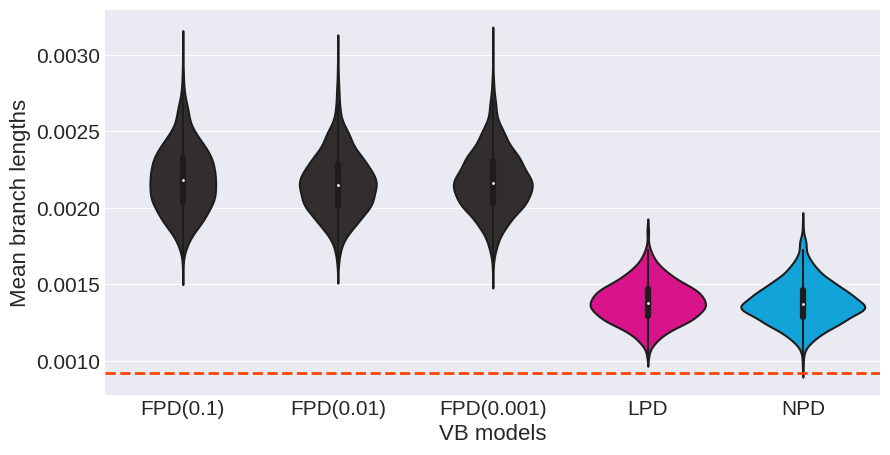

In [91]:
true_blen_mean = blens.mean().item() # horizontal line
violinplot_from_dataframe(df_bl_mean, 
                          line=true_blen_mean, 
                          y_limit=[None, None], 
                          xlabel="VB models", 
                          ylabel="Mean branch lengths",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

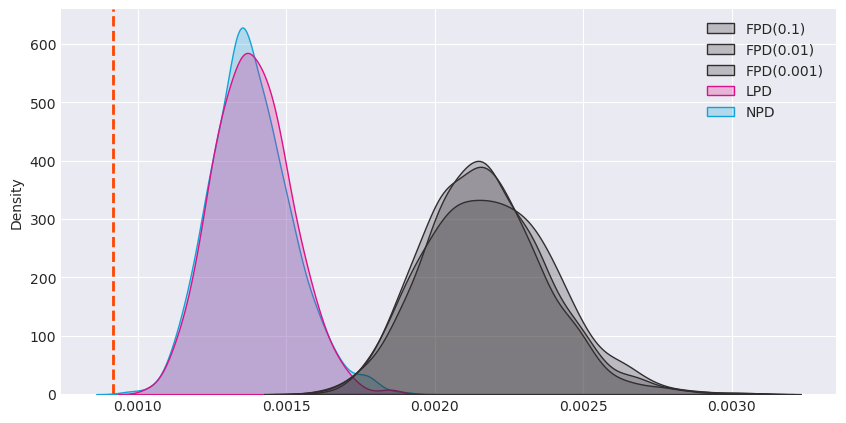

In [92]:
with plt.style.context('seaborn-darkgrid'):
    f, ax = plt.subplots(figsize=(10, 5))
    g = sns.kdeplot(ax=ax, data=df_bl_mean, palette=model_colors, fill=True)
    g.axvline(true_blen_mean, color="orangered", linestyle="--", linewidth=2)

### 4. Total tree length comparison

In [93]:
tree_lens = np.array([s.sum(1) for s in blen_samples])
tree_lens.shape

(5, 1000)

In [94]:
tree_lens = np.vstack(tree_lens).T
tree_lens.shape

(1000, 5)

In [95]:
df_tl = pd.DataFrame(data=tree_lens, columns=model_names)
df_tl.describe()

,FPD(0.1),FPD(0.01),FPD(0.001),LPD,NPD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.133566,0.131712,0.132743,0.084535,0.084333
std,0.013289,0.012351,0.012537,0.007981,0.008332
min,0.098091,0.098252,0.096386,0.062934,0.058770
25%,0.123851,0.122889,0.124045,0.078926,0.078712
50%,0.132950,0.131145,0.131953,0.084125,0.083628
75%,0.142342,0.139343,0.140634,0.089714,0.089396
max,0.186009,0.184782,0.187791,0.113595,0.115949


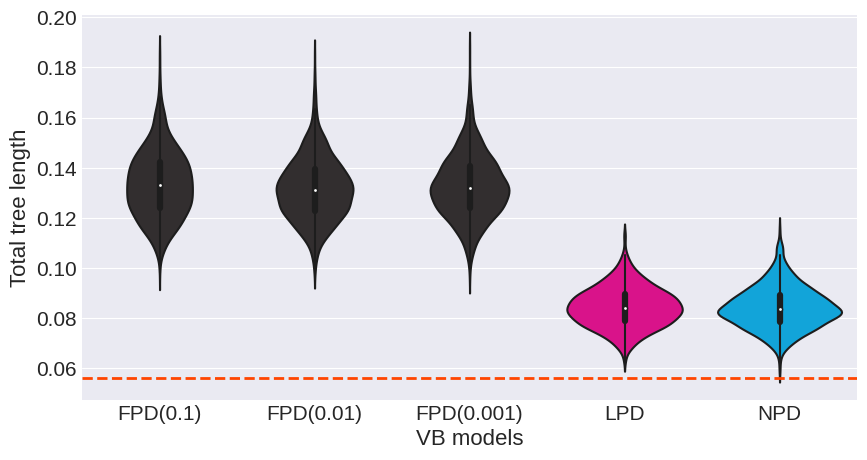

In [96]:
# import seaborn as sns
true_tree_len = blens.sum().item() # horizontal line
violinplot_from_dataframe(df_tl, 
                          line=true_tree_len, 
                          y_limit=[None, None],
                          xlabel="VB models", 
                          ylabel="Total tree length",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

## Comparison 2.  GTR rates estimation

In [97]:
# Model types
prior_hyperparams = [["dirichlet", [1.]*6 , False, "FPD(1)", "#322e2f"],
                     ["dirichlet", "uniform", True, "LPD", "#d9138a"],
                     ["dirichlet_nn", "uniform", True, "NPD", "#12a4d9"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

# Dataset types
kappas = [0.25, 1, 4]

rates = [np.array(compute_rates_from_kappa(k)) for k in kappas]
rates_str = [",".join(map(str, compute_rates_from_kappa(k))) for k in kappas]

rates_names = ["AG", "AC", "AT", "GC", "GT", "CT"] # see nnTreeVB/reports.py

### 1. Simulate a dataset

In [98]:
exp_mean_blens = 0.1
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 32

In [99]:
# Generate datasets from different rates values
datasets = []

for k in range(len(kappas)):
    fasta_file = 'sim_blens_{}_l{}_t{}_k{}.fasta'.format(str_exp_mean, aln_size, taxa_size, kappas[k])
    tree_file = 'sim_blens_{}_l{}_t{}_k{}.nw'.format(str_exp_mean, aln_size, taxa_size, kappas[k])

    # blens, obj_tree, X, X_counts
    datasets.append(simulate_exp_blens_dataset(
        fasta_file,
        tree_file,
        alignment_len=aln_size,
        nb_taxa=taxa_size,
        blen_mean=exp_mean_blens,
        rates_str=rates_str[k]))

### 2. Fit and sample VB models w/ different prior densities

In [100]:
# Fit and sample VB models with different prior densities on different datasets
from collections import defaultdict

rates_samples = defaultdict(list)

for k_ind in range(len(kappas)):
    blens, obj_tree, X, X_counts = datasets[k_ind]

    for i in range(len(prior_hyperparams)):
        print("\nVB model {}".format(prior_hyperparams[i][3]))

        model, samples = fit_sample_vb_model(obj_tree, X, X_counts,
                                             subs_model="gtr",
                                             r_prior_dist=prior_hyperparams[i][0],
                                             r_prior_params=prior_hyperparams[i][1],
                                             r_learn_prior=prior_hyperparams[i][2],
                                             verbose=1)

        rates_samples[k_ind].append(samples["r"])


VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. GTR rate samples

In [101]:
rates_samples[0][0].shape

(1000, 6)

In [102]:
k_ind = 2
dist_list = []
for i in range(len(prior_hyperparams)):
    scores = rates_samples[k_ind][i]
    
    dists = np.linalg.norm(rates[k_ind].reshape(1,-1) - scores, axis=-1)
    scaled_dists = 1-(1/(1+dists))

    dist_list.append(scaled_dists)

In [103]:
dist_list = np.array(dist_list)
dist_list.shape

(3, 1000)

In [104]:
dist_list = np.vstack(dist_list).T
dist_list.shape

(1000, 3)

In [105]:
df_rate_dists = pd.DataFrame(data=dist_list, columns=model_names)
df_rate_dists.describe()

,FPD(1),LPD,NPD
count,1000.000000,1000.000000,1000.000000
mean,0.020652,0.012445,0.013556
std,0.005969,0.004208,0.004259
min,0.005187,0.002292,0.002158
25%,0.016208,0.009667,0.010434
50%,0.020035,0.012256,0.013326
75%,0.024607,0.014786,0.016258
max,0.039745,0.035039,0.031755


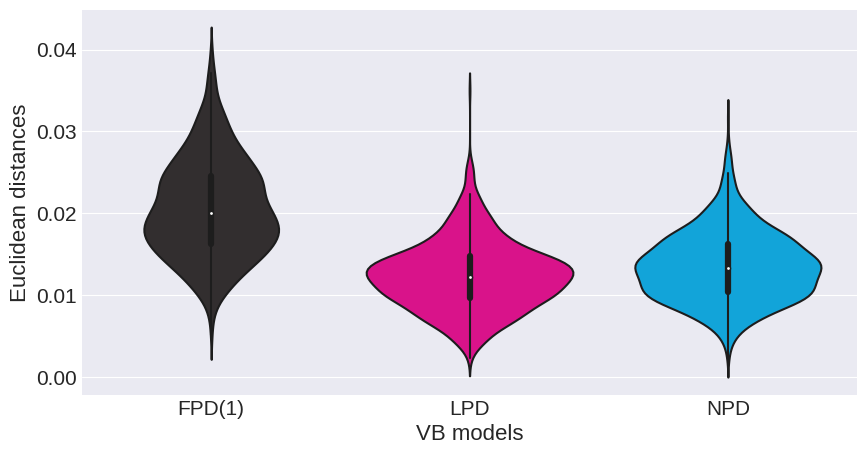

In [106]:
violinplot_from_dataframe(df_rate_dists, 
                          line="False", 
                          y_limit=[None, None], 
                          xlabel="VB models", 
                          ylabel="Euclidean distances",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

In [107]:
# Transform to a dataframe
df_rates = pd.DataFrame(columns=["Model", "K", "Rate", "Samples", "Real"])
sample_size = rates_samples[0][0].shape[0]

In [108]:
for k_ind in range(len(kappas)):
    for i in range(len(prior_hyperparams)):
        for r, rate in enumerate(rates_names):
            values = list()
            values.append([prior_hyperparams[i][3]]*sample_size) # Model
            values.append([kappas[k_ind]]*sample_size)           # K
            values.append([rate]*sample_size)                    # Rate
            values.append(rates_samples[k_ind][i][:,r])   # Sample values
            values.append([rates[k_ind][r]]*sample_size)    # Real value
            values = list(np.array(values, dtype="O").T)

            df_rates = pd.concat([df_rates, pd.DataFrame(values, columns=df_rates.columns)], ignore_index=True, copy=True)

In [109]:
df_rates.head()

,Model,K,Rate,Samples,Real
0,FPD(1),0.25,AG,0.054921,0.055556
1,FPD(1),0.25,AG,0.064308,0.055556
2,FPD(1),0.25,AG,0.060845,0.055556
3,FPD(1),0.25,AG,0.062884,0.055556
4,FPD(1),0.25,AG,0.064393,0.055556


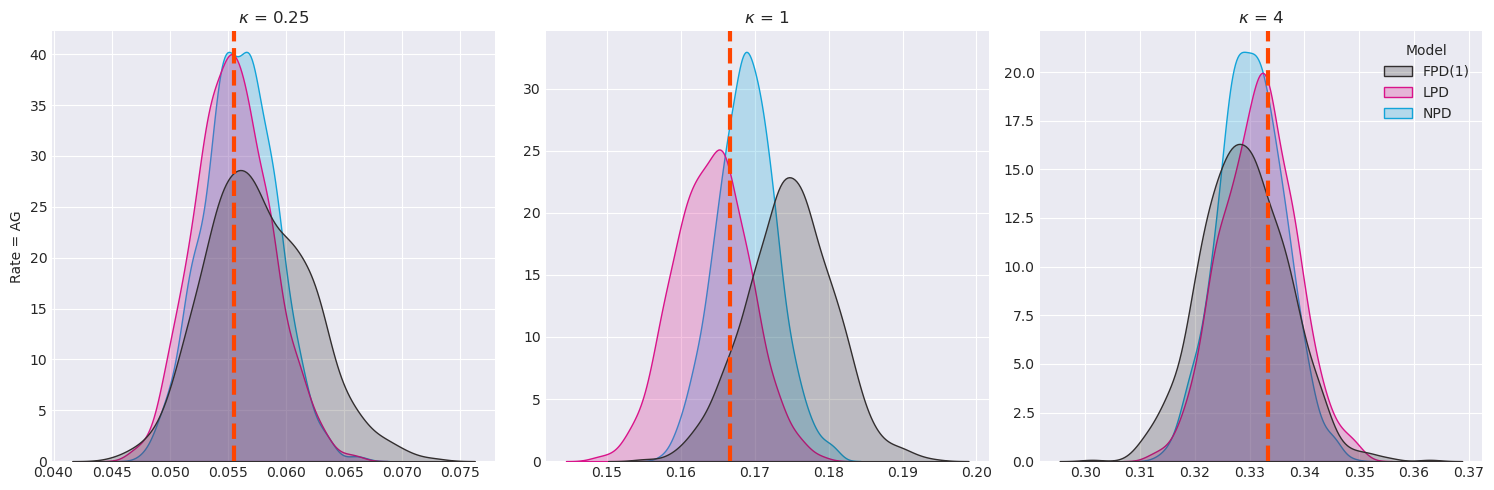

In [110]:
the_rate = "AG"

with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(1, 3, figsize=(15, 5))
    for k_ind, k in enumerate(kappas):
        legend = False
        if k_ind == len(kappas)-1: legend = True
        else: legend = False

        axe = axes[k_ind]
        data = df_rates[(df_rates["Rate"]==the_rate)&(df_rates["K"]==k)]

        g=sns.kdeplot(ax=axe, 
                      data=data, 
                      x="Samples",
                      hue="Model",
                      fill=True,
                      palette=model_colors,
                      legend=legend)

        x = data["Real"].unique().item()
        axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

        axe.set_title(r"$\kappa$ = {}".format(k))
        axe.set(xlabel=None)

        if k_ind !=0: 
            axe.set(ylabel=None)
        else:
            axe.set(ylabel=r"Rate = {}".format(the_rate))

    plt.tight_layout()

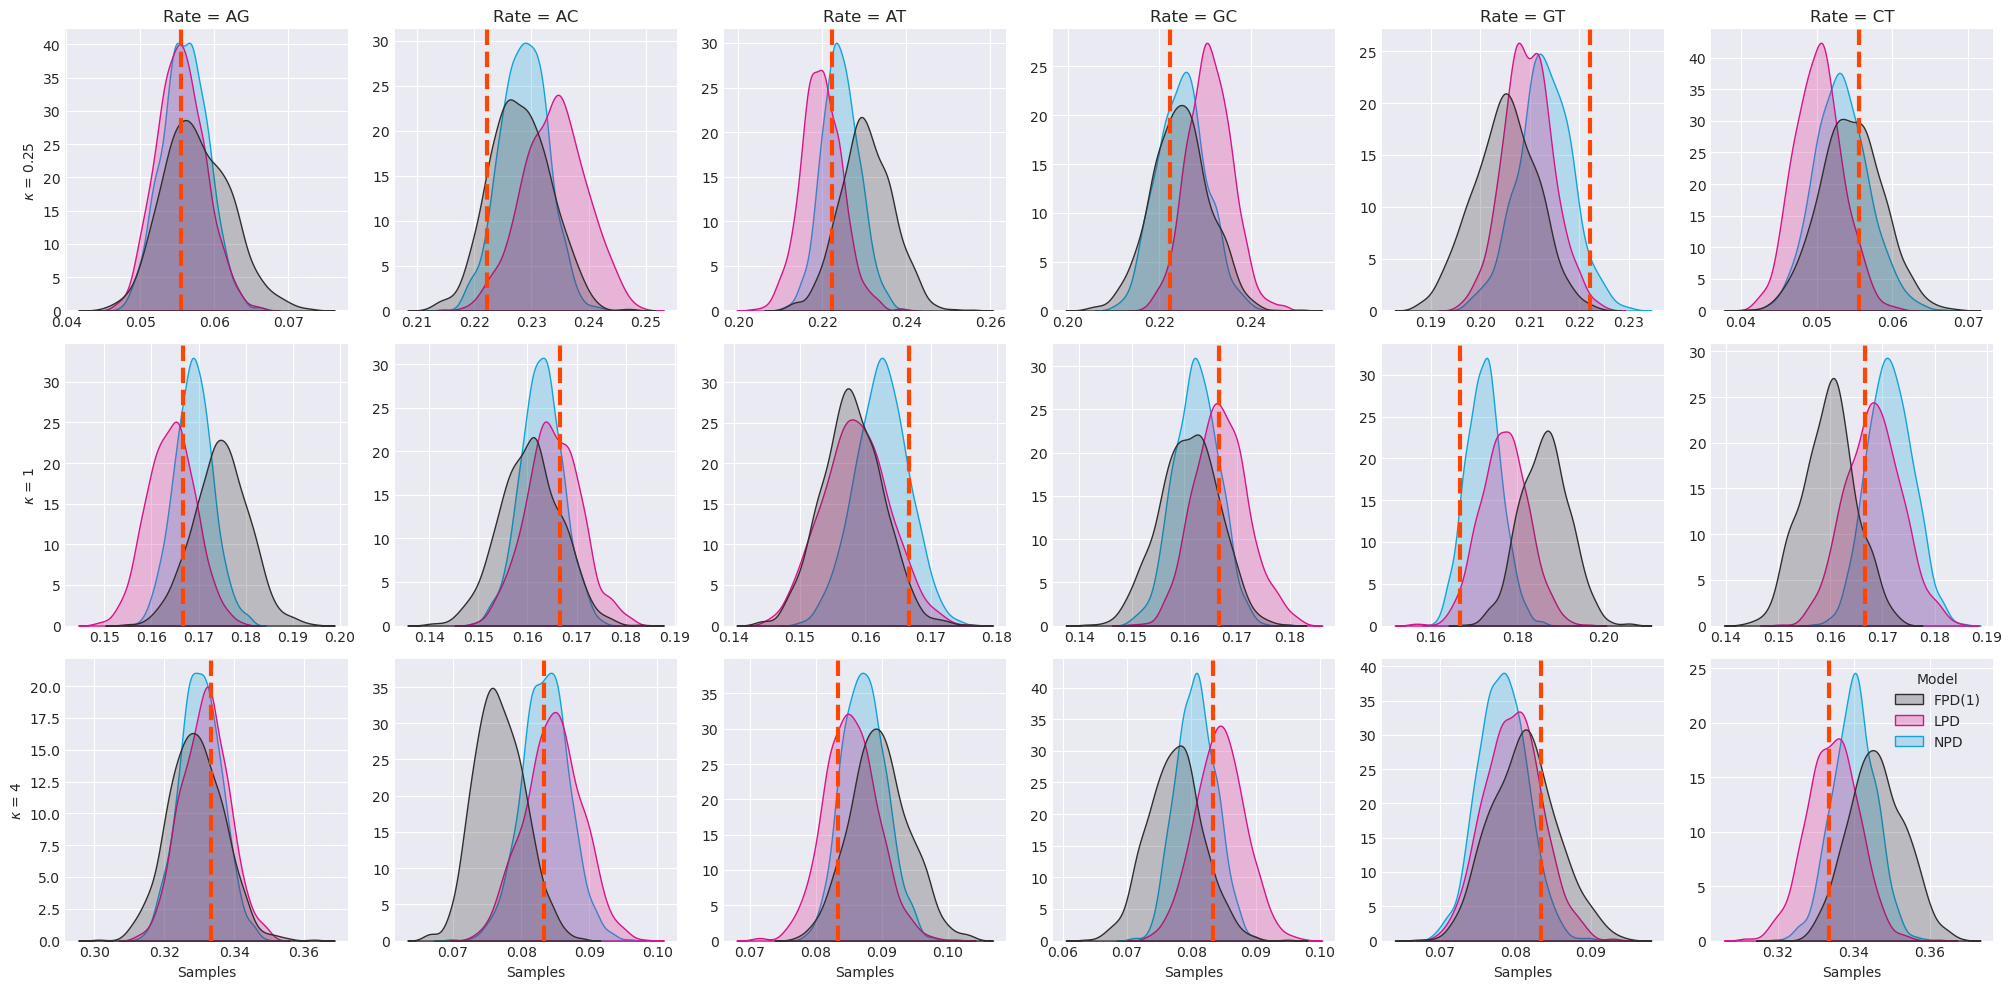

In [111]:
with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(len(kappas), len(rates_names), figsize=(20, 10))
#     plt.subplots_adjust(wspace=0.15, hspace=0.3)

    # Rows
    for k_ind, k in enumerate(kappas):
        # Columns
        for r_ind, r in enumerate(rates_names):
            legend = False
            if k_ind == len(kappas)-1 and r_ind == len(rates_names)-1: legend = True
            else: legend = False

            axe = axes[k_ind][r_ind]
            data = df_rates[(df_rates["K"]==k)&(df_rates["Rate"]==r)]

            g=sns.kdeplot(ax=axe, data=data, x="Samples", hue="Model", fill=True, palette=model_colors, legend=legend)

            x = data["Real"].unique().item()
            axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

            if k_ind == 0: axe.set_title(r"Rate = {}".format(rates_names[r_ind]))
            if k_ind != 2: axe.set(xlabel=None)
            if r_ind !=0: 
                axe.set(ylabel=None)
            else:
                axe.set(ylabel=r"$\kappa$ = {}".format(k))

plt.tight_layout() 

## Comparison 3.  GTR relative frequencies estimation

In [112]:
# Model types
prior_hyperparams = [["dirichlet", [1.]*4 , False, "FPD(1)", "#322e2f"],
                     ["dirichlet", "uniform", True, "LPD", "#d9138a"],
                     ["dirichlet_nn", "uniform", True, "NPD", "#12a4d9"]
                    ]

model_names = [m[3] for m in prior_hyperparams]
model_colors = [m[4] for m in prior_hyperparams]

distr_freqs = ["dirichlet(10,1,1,10)",
               "dirichlet(10,10,10,10)",
               "dirichlet(1,10,10,1)"
              ]

distr_names = ["dir-10AT", "dir-10", "dir-10GC"]

# Each time, you run this cell, check_sim_simplex samples new values for freqs
freqs_str = [",".join(map(str, check_sim_simplex(distr, 4)[0])) for distr in distr_freqs]

freqs_list = np.array([list(map(float, f.split(","))) for f in freqs_str])

freqs_names = ["A", "G", "C", "T"]

### 1. Simulate a dataset

In [113]:
exp_mean_blens = 0.1
str_exp_mean = str(exp_mean_blens).replace(".", "")
aln_size = 1000
taxa_size = 32

In [114]:
# Generate datasets from different rates values
datasets = []

for f_ind, freq_str in enumerate(freqs_str):
    distr_name = distr_names[f_ind]
    fasta_file = 'sim_blens_{}_l{}_t{}_f{}.fasta'.format(str_exp_mean, aln_size, taxa_size, distr_name)
    tree_file = 'sim_blens_{}_l{}_t{}_f{}.nw'.format(str_exp_mean, aln_size, taxa_size, distr_name)

    # blens, obj_tree, X, X_counts
    datasets.append(simulate_exp_blens_dataset(
        fasta_file,
        tree_file,
        alignment_len=aln_size,
        nb_taxa=taxa_size,
        blen_mean=exp_mean_blens,
        freqs_str=freq_str))

### 2. Fit and sample VB models w/ different prior densities

In [115]:
# Fit and sample VB models with different prior densities on different datasets
from collections import defaultdict

freqs_samples = defaultdict(list)

for fs_ind, freqs in enumerate(freqs_list):
    blens, obj_tree, X, X_counts = datasets[fs_ind]

    for i in range(len(prior_hyperparams)):
        print("\nVB model {}".format(prior_hyperparams[i][3]))

        model, samples = fit_sample_vb_model(obj_tree, X, X_counts,
                                             subs_model="gtr",
                                             f_prior_dist=prior_hyperparams[i][0],
                                             f_prior_params=prior_hyperparams[i][1],
                                             f_learn_prior=prior_hyperparams[i][2],
                                             verbose=1)

        freqs_samples[fs_ind].append(samples["f"])


VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model

VB model FPD(1)
	Initialize the model
	Fit the model
	Sample from the model

VB model LPD
	Initialize the model
	Fit the model
	Sample from the model

VB model NPD
	Initialize the model
	Fit the model
	Sample from the model


### 3. GTR frequencies samples

In [116]:
freqs_samples[0][0].shape

(1000, 4)

In [117]:
f_ind = 0
f_dist_list = []
for i in range(len(prior_hyperparams)):
    scores = freqs_samples[f_ind][i]
    
    dists = np.linalg.norm(freqs[f_ind].reshape(1,-1) - scores, axis=-1)
    scaled_dists = 1-(1/(1+dists))

    f_dist_list.append(scaled_dists)

In [118]:
f_dist_list = np.array(f_dist_list)
f_dist_list.shape

(3, 1000)

In [119]:
f_dist_list = np.vstack(f_dist_list).T
f_dist_list.shape

(1000, 3)

In [120]:
df_freq_dists = pd.DataFrame(data=f_dist_list, columns=model_names)
df_freq_dists.describe()

,FPD(1),LPD,NPD
count,1000.000000,1000.000000,1000.000000
mean,0.369012,0.368886,0.369933
std,0.001202,0.001056,0.000985
min,0.365167,0.365935,0.366948
25%,0.368165,0.368131,0.369266
50%,0.368990,0.368873,0.369951
75%,0.369860,0.369603,0.370587
max,0.372573,0.371823,0.373409


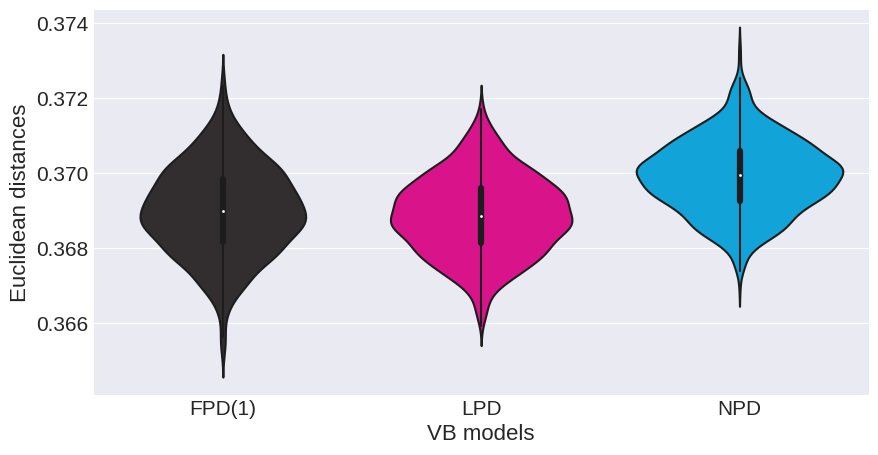

In [121]:
violinplot_from_dataframe(df_freq_dists, 
                          line="", 
                          y_limit=[None, None], 
                          xlabel="VB models", 
                          ylabel="Euclidean distances",
                          palette=model_colors,
                          xticks_rotation=0,
                          fig_size=(10,5)
                         )

In [122]:
# Transform to a dataframe
df_freqs = pd.DataFrame(columns=["Model", "Dir", "Freq", "Samples", "Real"])
sample_size = freqs_samples[0][0].shape[0]

In [123]:
for fs_ind, freqs in enumerate(freqs_list):
    distr_name = distr_names[fs_ind]

    for i in range(len(prior_hyperparams)):
        for f_ind, freq in enumerate(freqs_names):
            values = list()
            values.append([prior_hyperparams[i][3]]*sample_size) # Model
            values.append([distr_name]*sample_size)              # Dir
            values.append([freq]*sample_size)                    # Freq name
            values.append(freqs_samples[fs_ind][i][:,f_ind])     # Sample values
            values.append([freqs[f_ind]]*sample_size)    # Real value
            values = list(np.array(values, dtype="O").T)

            df_freqs = pd.concat([df_freqs, pd.DataFrame(values, columns=df_freqs.columns)], 
                                 ignore_index=True, 
                                 copy=True)

In [124]:
df_freqs.head()

,Model,Dir,Freq,Samples,Real
0,FPD(1),dir-10AT,A,0.311820,0.308735
1,FPD(1),dir-10AT,A,0.315547,0.308735
2,FPD(1),dir-10AT,A,0.317603,0.308735
3,FPD(1),dir-10AT,A,0.313462,0.308735
4,FPD(1),dir-10AT,A,0.317974,0.308735


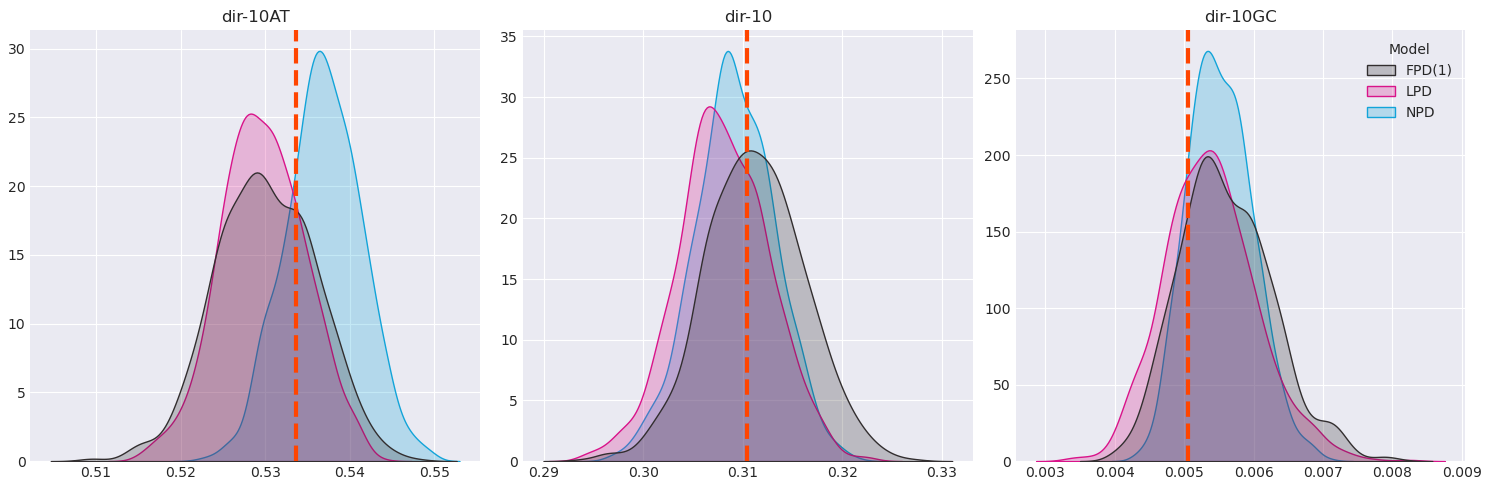

In [125]:
the_freq = "T"

with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(1, 3, figsize=(15, 5))
    for fs_ind, freqs in enumerate(freqs_list):
        distr_name = distr_names[fs_ind]

        legend = False
        if fs_ind == len(freqs_str)-1: legend = True
        else: legend = False

        axe = axes[fs_ind]
        data = df_freqs[(df_freqs["Freq"]==the_freq)&(df_freqs["Dir"]==distr_name)]

        g=sns.kdeplot(ax=axe, 
                      data=data, 
                      x="Samples",
                      hue="Model",
                      fill=True,
                      palette=model_colors,
                      legend=legend)

        x = data["Real"].unique().item()
        axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

        axe.set_title(r"{}".format(distr_name))
        axe.set(xlabel=None)

        if k_ind !=0: 
            axe.set(ylabel=None)
        else:
            axe.set(ylabel=r"{}".format(the_freq))

    plt.tight_layout()

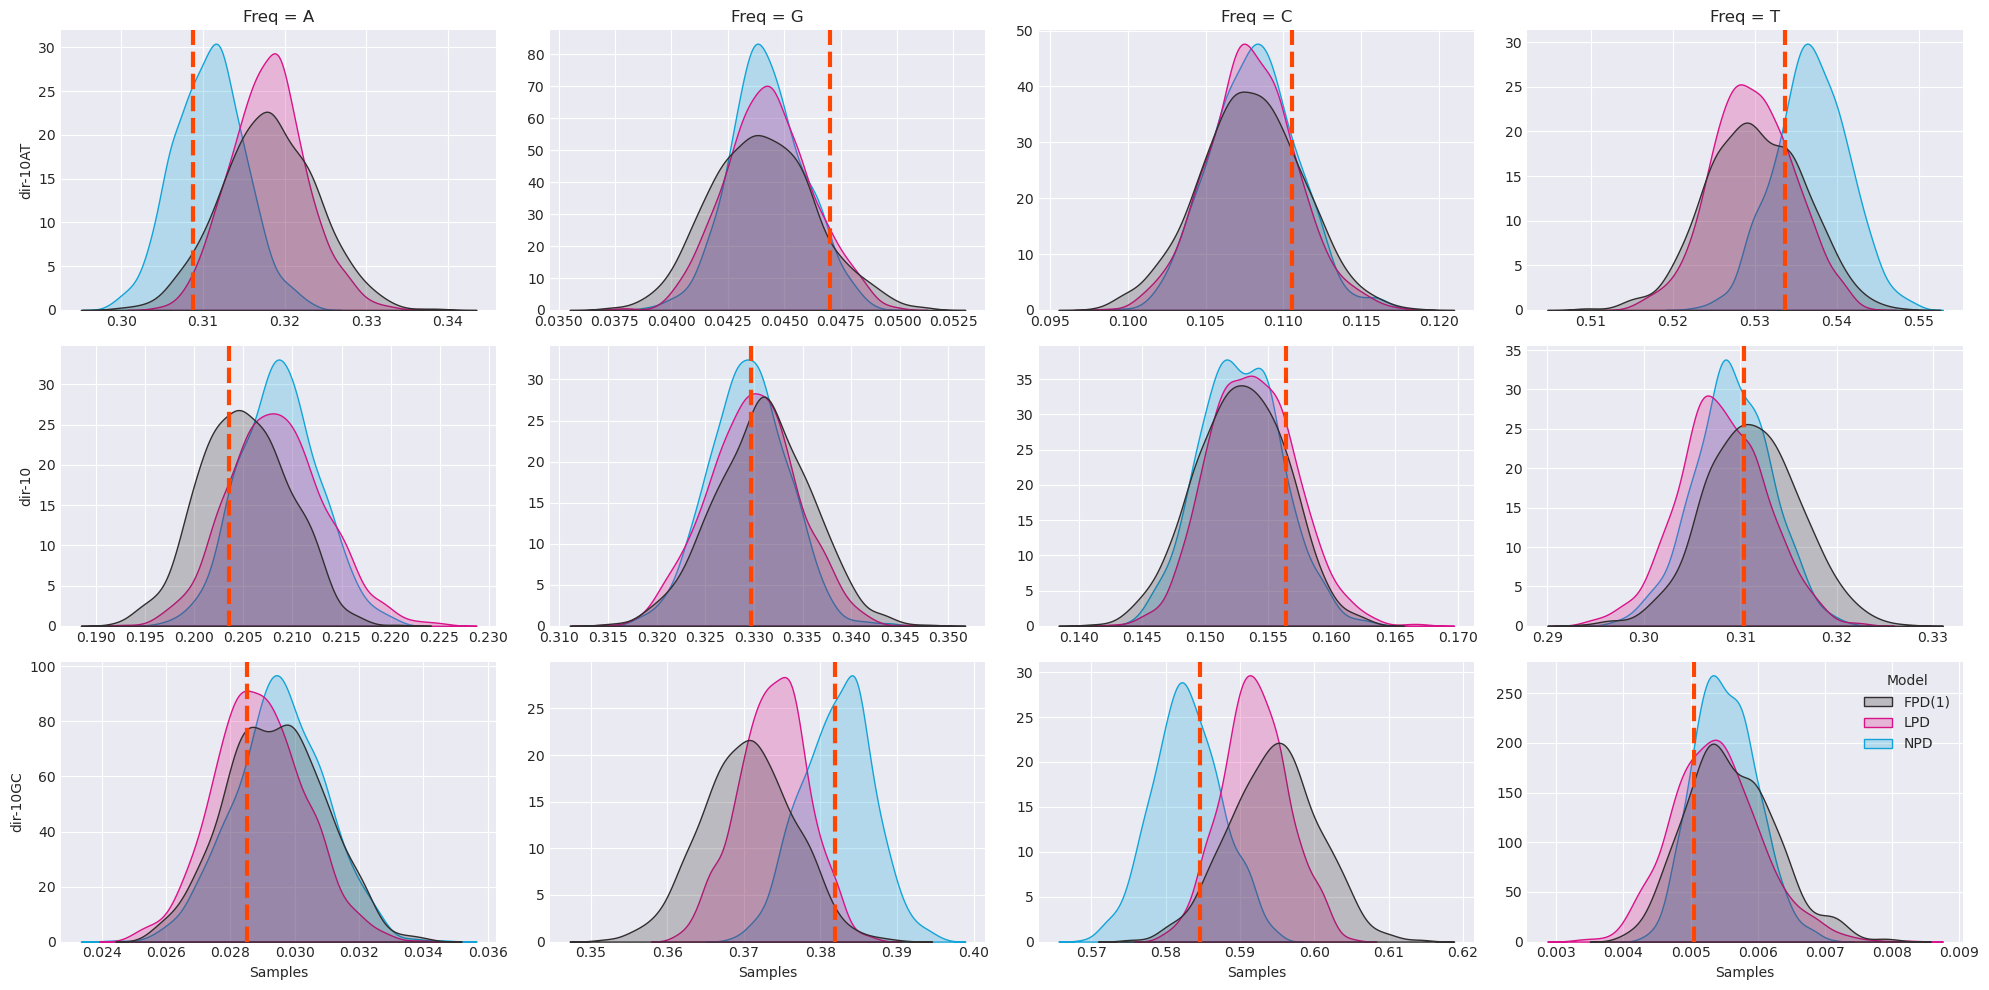

In [126]:
with plt.style.context('seaborn-darkgrid'):
    f, axes = plt.subplots(len(freqs_list), len(freqs_names), figsize=(20, 10))
#     plt.subplots_adjust(wspace=0.15, hspace=0.3)

    # Rows
    for fs_ind, freqs in enumerate(freqs_list):
        distr_name = distr_names[fs_ind]
        # Columns
        for f_ind, freq_name in enumerate(freqs_names):
            legend = False
            if fs_ind == len(freqs_list)-1 and f_ind == len(freqs_names)-1: legend = True
            else: legend = False

            axe = axes[fs_ind][f_ind]
            data = df_freqs[(df_freqs["Dir"]==distr_name)&(df_freqs["Freq"]==freq_name)]

            g=sns.kdeplot(ax=axe, data=data, x="Samples", hue="Model",
                          fill=True, palette=model_colors, legend=legend)

            x = data["Real"].unique().item()
            axe.axvline(x, color="orangered", linestyle="--", linewidth=3)

            if fs_ind == 0: axe.set_title(r"Freq = {}".format(freq_name))
            if fs_ind != 2: axe.set(xlabel=None)
            if f_ind !=0: 
                axe.set(ylabel=None)
            else:
                axe.set(ylabel=r"{}".format(distr_name))

plt.tight_layout()